#### Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

pd.set_option('display.max_columns',None)
%matplotlib inline
sns.set_theme()

# Data

In [210]:
df = pd.read_csv('data/vehicles.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (70,71,72,73,74,76,79) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
df.head()

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
0,15.695714,0.0,0.0,0.0,19,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,423.190476,21,0.0,0,0.0,0.0,0.0,0.0,4.0,2.0,Rear-Wheel Drive,9011,(FFS),-1,2050,0,Regular,Regular Gasoline,-1,-1,25,0.0,0,0.0,0.0,0.0,0.0,0,0,1,0,0,Alfa Romeo,Spider Veloce 2000,Y,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,23.3333,0.0,35.0000,0.0,Two Seaters,1985,-2250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
1,29.964545,0.0,0.0,0.0,9,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,807.909091,11,0.0,0,0.0,0.0,0.0,0.0,12.0,4.9,Rear-Wheel Drive,22020,(GUZZLER),-1,3900,0,Regular,Regular Gasoline,-1,-1,14,0.0,0,0.0,0.0,0.0,0.0,0,0,10,0,0,Ferrari,Testarossa,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,11.0000,0.0,19.0000,0.0,Two Seaters,1985,-11500,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
2,12.207778,0.0,0.0,0.0,23,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,329.148148,27,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,Front-Wheel Drive,2100,(FFS),-1,1600,0,Regular,Regular Gasoline,-1,-1,33,0.0,0,0.0,0.0,0.0,0.0,19,77,100,0,0,Dodge,Charger,Y,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,29.0000,0.0,47.0000,0.0,Subcompact Cars,1985,0,NaN,SIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
3,29.964545,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,807.909091,11,0.0,0,0.0,0.0,0.0,0.0,8.0,5.2,Rear-Wheel Drive,2850,NaN,-1,3900,0,Regular,Regular Gasoline,-1,-1,12,0.0,0,0.0,0.0,0.0,0.0,0,0,1000,0,0,Dodge,B150/B250 Wagon 2WD,N,False,0,0,0,0.0,0.0,0.0,0.0,Automatic 3-spd,12.2222,0.0,16.6667,0.0,Vans,1985,-11500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
4,17.347895,0.0,0.0,0.0,17,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,467.736842,19,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,66031,"(FFS,TRBO)",-1,2750,0,Premium,Premium Gasoline,-1,-1,23,0.0,0,0.0,0.0,0.0,0.0,0,0,10000,0,14,Subaru,Legacy AWD Turbo,N,False,0,90,0,0.0,0.0,0.0,0.0,Manual 5-spd,21.0000,0.0,32.0000,0.0,Compact Cars,1993,-5750,NaN,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0


In [7]:
df.trans_dscr

0          NaN
1          NaN
2          SIL
3          NaN
4          NaN
         ...  
43491    CLKUP
43492      NaN
43493    CLKUP
43494      NaN
43495    CLKUP
Name: trans_dscr, Length: 43496, dtype: object

In [57]:
df.describe()

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,engId,feScore,fuelCost08,fuelCostA08,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,UCity,UCityA,UHighway,UHighwayA,year,youSaveSpend,charge240b,phevCity,phevHwy,phevComb
count,43496.000000,43496.000000,43496.0,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43213.000000,43215.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000,43496.000000
mean,17.127779,0.221471,0.0,0.067088,18.666774,6.949352,0.779405,0.642259,0.000496,0.473978,0.002564,104.308626,5.897899,17.183718,462.068075,20.906796,7.721011,0.835387,0.676864,0.481991,0.000383,0.002539,5.710527,3.284362,7739.078996,0.599848,2387.322972,83.253633,0.600239,-0.921487,24.781727,9.057181,0.935029,0.744543,0.000253,0.492140,0.002504,1.979768,10.098032,21886.725285,1.781382,6.036647,13.387139,33.526623,1.202432,1.186530,0.143121,1.117373,0.133171,23.631008,1.026159,34.290752,1.268663,2002.570397,-3926.349549,0.014330,0.229423,0.231148,0.229216
std,4.680931,1.141130,0.0,0.745826,8.795557,12.704089,6.044736,5.933857,0.038195,4.690196,0.037409,185.649458,57.279464,92.470225,125.277363,8.438982,13.304178,6.029127,5.876293,4.719289,0.033258,0.036991,1.765504,1.356980,16882.080452,2.848080,666.693803,442.275854,2.852124,0.654165,8.312073,14.724613,6.180606,5.963139,0.027678,4.775606,0.036460,5.911747,27.858277,12699.602673,4.330655,9.562456,30.938477,45.995457,16.845952,17.082608,2.624508,16.321356,2.351172,12.506121,8.520592,12.481812,8.673869,11.668704,3344.123260,0.303454,3.523000,3.402284,3.446651
min,0.060000,0.000000,0.0,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,-1.000000,450.000000,0.000000,-1.000000,-1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1984.000000,-29500.000000,0.000000,0.000000,0.000000,0.000000
25%,14.330870,0.000000,0.0,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,386.391304,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.200000,0.000000,-1.000000,1950.000000,0.000000,-1.000000,-1.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10874.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.400000,0.000000,27.771800,0.000000,1992.000000,-5750.000000,0.000000,0.000000,0.000000,0.000000
50%,16.480500,0.000000,0.0,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,444.350000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,3.000000,164.000000,-1.000000,2400.000000,0.000000,-1.000000,-1.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21752.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.668850,0.000000,33.328300,0.000000,2004.0

# Cleaning

In [211]:
# Cleaning: Setting vehicle guzzler class to binary
df['guzzler'] = np.where(((df.guzzler == 'G')
                        | (df.guzzler == 'T')
                        | (df.guzzler == 'S')),
                            1,
                            0)

# Cleaning: imputing cylinders to 4
df['cylinders'] = np.where((df.make == 'Subaru') 
                         & (df.model == 'RX Turbo'),
                           4,
                           df.cylinders) 
                           
df.drop(index=21500, inplace=True) # Cleaning: dropping duplicate data entry

# Cleaning: Sets cylinders to 0 for all electric vehicles with NaN values
df['cylinders'] = np.where(df.cylinders.isna(),
                           0,
                           df.cylinders)

# Cleaning: Setting to dummy binary class while simultaneously managing NaN values
df['startStop'] = np.where((df.startStop == 'Y'),
                          1,
                          0)

# Cleaning: Setting from boolean to binary class
df['phevBlended'] = np.where(df.phevBlended == True,
                            1,
                            0)

In [236]:
df = df[['year', 
         'make', # drop when modeling
         'model', # drop when modeling'barrels08', 
         'comb08', 
         'comb08U',
         'combA08', 
         'combA08U', 
         'combE', 
         'phevComb', # PHEV TARGET
         'combinedCD', 
         'combinedUF', 
         'barrels08', 
         'barrelsA08', 
         'cylinders', # clean
         'displ', 
         'drive', 
         'eng_dscr', # such a mess
         'evMotor', # such a mess
         'trany', 
         'trans_dscr', 
         'fuelType1', 
         'fuelType2', 
         'hlv', 
         'hpv', 
         'lv2', 
         'lv4', 
         'pv2', 
         'pv4', 
         'VClass', 
         'phevBlended', 
         'youSaveSpend', 
         'guzzler', # cleaned, may drop due to relation to eng_dscr
         'tCharger', 
         'sCharger', 
         'atvType', 
         'charge120', 
         'charge240', 
         'c240Dscr', 
         'charge240b', 
         'c240bDscr',
         'co2',
         'co2A', 
         'co2TailpipeAGpm', 
         'co2TailpipeGpm', 
#          'id', 
#          'engId', 
#          'feScore', 
#          'fuelCost08',
#          'fuelCostA08', 
#          'fuelType', 
#          'ghgScore', 
#          'ghgScoreA',
#          'city08', 
#          'city08U', 
#          'cityA08', 
#          'cityA08U', 
#          'cityCD', 
#          'cityE', 
#          'cityUF', 
#          'UCity', 
#          'UCityA',
#          'UHighway', 
#          'UHighwayA', 
#          'highway08', 
#          'highway08U', 
#          'highwayA08', 
#          'highwayA08U', 
#          'highwayCD',
#          'highwayE', 
#          'highwayUF',
#          'phevCity', 
#          'phevHwy',
#          'mpgData', 
#          'range', 
#          'rangeA',
#          'rangeCity',
#          'rangeCityA', 
#          'rangeHwy', 
#          'rangeHwyA', 
#          'createdOn', 
#          'modifiedOn', 
#          'startStop', 
        ]]

In [237]:
df

,year,make,model,comb08,comb08U,combA08,combA08U,combE,phevComb,combinedCD,combinedUF,barrels08,barrelsA08,cylinders,displ,drive,eng_dscr,evMotor,trany,trans_dscr,fuelType1,fuelType2,hlv,hpv,lv2,lv4,pv2,pv4,VClass,phevBlended,youSaveSpend,guzzler,tCharger,sCharger,atvType,charge120,charge240,c240Dscr,charge240b,c240bDscr,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm
0,1985,Alfa Romeo,Spider Veloce 2000,21,0.0,0,0.0,0.0,0,0.0,0.0,15.695714,0.0,4.0,2.0,Rear-Wheel Drive,(FFS),NaN,Manual 5-spd,NaN,Regular Gasoline,NaN,0,0,0,0,0,0,Two Seaters,0,-2250,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,-1,-1,0.0,423.190476
1,1985,Ferrari,Testarossa,11,0.0,0,0.0,0.0,0,0.0,0.0,29.964545,0.0,12.0,4.9,Rear-Wheel Drive,(GUZZLER),NaN,Manual 5-spd,NaN,Regular Gasoline,NaN,0,0,0,0,0,0,Two Seaters,0,-11500,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,-1,-1,0.0,807.909091
2,1985,Dodge,Charger,27,0.0,0,0.0,0.0,0,0.0,0.0,12.207778,0.0,4.0,2.2,Front-Wheel Drive,(FFS),NaN,Manual 5-spd,SIL,Regular Gasoline,NaN,19,77,0,0,0,0,Subcompact Cars,0,0,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,-1,-1,0.0,329.148148
3,1985,Dodge,B150/B250 Wagon 2WD,11,0.0,0,0.0,0.0,0,0.0,0.0,29.964545,0.0,8.0,5.2,Rear-Wheel Drive,NaN,NaN,Automatic 3-spd,NaN,Regular Gasoline,NaN,0,0,0,0,0,0,Vans,0,-11500,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,-1,-1,0.0,807.909091
4,1993,Subaru,Legacy AWD Turbo,19,0.0,0,0.0,0.0,0,0.0,0.0,17.347895,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,"(FFS,TRBO)",NaN,Manual 5-spd,NaN,Premium Gasoline,NaN,0,0,0,14,0,90,Compact Cars,0,-5750,0,T,NaN,NaN,0.0,0.0,NaN,0.0,NaN,-1,-1,0.0,467.736842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43491,1993,Subaru,Legacy,22,0.0,0,0.0,0.0,0,0.0,0.0,14.982273,0.0,4.0,2.2,Front-Wheel Drive,(FFS),NaN,Automatic 4-spd,CLKUP,Regular Gasoline,NaN,0,0,0,14,0,90,Compact Cars,0,-1750,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,-1,-1,0.0,403.954545
43492,1993,Subaru,Legacy,23,0.0,0,0.0,0.0,0,0.0,0.0,14.330870,0.0,4.0,2.2,Front-Wheel Drive,(FFS),NaN,Manual 5-spd,NaN,Regular Gasoline,NaN,0,0,0,14,0,90,Compact Cars,0,-1250,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,-1,-1,0.0,386.391304
43493,1993,Subaru,Legacy AWD,21,0.0,0,0.0,0.0,0,0.0,0.0,15.695714,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,(FFS),NaN,Automatic 4-spd,CLKUP,Regular Gasoline,NaN,0,0,0,14,0,90,Compact Cars,0,-2250,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,-1,-1,0.0,423.190476
43494,1993,Subaru,Legacy AWD,21,0.0,0,0.0,0.0,0,0.0,0.0,15.695714,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,(FFS),NaN,Manual 5-spd,NaN,Regular Gasoline,NaN,0,0,0,14,0,90,Compact Cars,0,-2250,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,-1,-1,0.0,423.190476


# EDA

## Dataset Description

The dataset comes with **83 features** and 43,496 rows.  
  
  Each row is a different vehicle, though there are instances where vehicles have the same make, model, year, and even transmission. Despite this, it appears that each vehicle is unique from the others. For example, the vehicle with the most common repeated make/model/year/drivetrain in the dataset is the Ford F150 Pickup 2WD. There are 16 of this particular model, with 6 among them having an Automatic 3-speed transmission. Yet all Ford F150s have unique engine IDs, and usually differ in other ways, which leads me to suspect that all row items are unique vehicles.

In [95]:
df[(df.model == 'F150 Pickup 2WD') & (df.year == 1984)].engId.values

array([3817, 3825, 3828, 3826, 3839, 3837, 3834, 3838, 3851, 3849, 3850,
       3857, 3876, 3869, 3874, 3873, 3886, 3891, 3828])

#### Key Terms:

- **PHEV** — Plug-in Hybrid Electric Vehicle
- **BEV** — Battery Electric Vehicle - **no gas engine whatsoever**  
- **HEV** — Hybrid Electric Vehicle - predominantly gas powered, has no plug to charge, and electric powered engine only operates at low speeds, typically.
- **EV** — Electric Vehicle  
  
  
- **ZEV** — Zero Emission Vehicle  
  
  
- **ICE** — Internal Combustion Engine

### Missing Values

The following columns have a small number of null values. I will likely manage nulls in this instance primarily by dropping rows that have null values.
- **cylinders** — 283
- **displ** — 281
- **drive** — 1186
- **trany** — 11  
  
The following columns have a significant number of null values and may be dropped entirely. I will evaluate the dataset description to decide which may be instead appropriate to impute to a nominal value instead.
- **eng_dscr** — 16538
- **guzzler** — 40934
- **trans_dscr** — 28452
- **tCharger** — 35305
- **sCharger** — 42580
- **atvType** — 39505
- **fuelType2** — 41765
- **rangeA** — 41770
- **evMotor** — 42271
- **mfrCode** — 30808
- **c240Dscr** — 43380
- **c240bDscr** — 43386
- **startStop** — 31689

In [14]:
pd.set_option('display.max_rows', 1000)
df.isna().sum()

barrels08              0
barrelsA08             0
charge120              0
charge240              0
city08                 0
city08U                0
cityA08                0
cityA08U               0
cityCD                 0
cityE                  0
cityUF                 0
co2                    0
co2A                   0
co2TailpipeAGpm        0
co2TailpipeGpm         0
comb08                 0
comb08U                0
combA08                0
combA08U               0
combE                  0
combinedCD             0
combinedUF             0
cylinders            283
displ                281
drive               1186
engId                  0
eng_dscr           16538
feScore                0
fuelCost08             0
fuelCostA08            0
fuelType               0
fuelType1              0
ghgScore               0
ghgScoreA              0
highway08              0
highway08U             0
highwayA08             0
highwayA08U            0
highwayCD              0
highwayE               0


### `year`

- Year of vehicle model

### `make` / `model`

### barrels-x

In [ ]:
df.barrel

- **barrels08** - annual petroleum consumption in barrels for fuelType1 
- **barrelsA08** - annual petroleum consumption in barrels for fuelType2

### `charge120` / `charge240` / `c240Dscr` / `charge240b` / `c240bDscr`

- **charge120** - time to charge an electric vehicle in hours at 120 V
- **charge240** - time to charge an electric vehicle in hours at 240 V  
- **c240Dscr** - electric vehicle charger description
- **charge240b** - time to charge an electric vehicle in hours at 240 V using the alternate charger
- **c240bDscr** - electric vehicle alternate charger description

### `comb08U` / `combA08U` / `combE` / `combinedCD` / `combinedUF`

- **comb08** - combined MPG for fuelType1 (2), (11) **DROP**
- **comb08U** - unrounded combined MPG for fuelType1 (2), (3) **TARGET**
- **combA08** - combined MPG for fuelType2 **DROP**
- **combA08U** - unrounded combined MPG for fuelType2 (2), (3)
- **combE** - combined electricity consumption in kw-hrs/100 miles
- **combinedCD** - combined gasoline consumption (gallons/100 miles) in charge depleting mode (4)
- **combinedUF** - EPA combined utility factor (share of electricity) for PHEV

- my target will be among these

In [180]:
df[df.comb08U != 0]

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
16780,11.943281,0.0,0.0,0.0,29,29.0000,0,0.0,0.0,0.0,0.0,318,-1,0.0,318.000000,32,32.0000,0,0.0,0.0,0.0,0.0,4.0,2.0,Front-Wheel Drive,0,NaN,-1,1500,0,Diesel,Diesel,-1,-1,37,37.0000,0,0.0,0.0,0.0,0.0,0,0,25262,0,16,Volkswagen,Jetta,Y,False,0,91,0,0.0,0.0,0.0,0.0,Automatic (S6),38.5034,0.0,56.6944,0.0,Compact Cars,2009,500,0,3MODE CLKUP,T,NaN,Diesel,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Wed Jul 26 00:00:00 EDT 2017,NaN,0,0,0
16781,11.943281,0.0,0.0,0.0,29,28.5000,0,0.0,0.0,0.0,0.0,315,-1,0.0,315.000000,32,32.3000,0,0.0,0.0,0.0,0.0,4.0,2.0,Front-Wheel Drive,0,NaN,-1,1500,0,Diesel,Diesel,-1,-1,39,38.5400,0,0.0,0.0,0.0,0.0,0,0,25263,0,16,Volkswagen,Jetta,Y,False,0,91,0,0.0,0.0,0.0,0.0,Manual 6-spd,38.6000,0.0,58.1000,0.0,Compact Cars,2009,500,0,NaN,T,NaN,Diesel,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Wed Jul 26 00:00:00 EDT 2017,NaN,0,0,0
16839,11.943281,0.0,0.0,0.0,29,29.0000,0,0.0,0.0,0.0,0.0,318,-1,0.0,318.000000,32,32.0000,0,0.0,0.0,0.0,0.0,4.0,2.0,Front-Wheel Drive,0,NaN,-1,1500,0,Diesel,Diesel,-1,-1,37,37.0000,0,0.0,0.0,0.0,0.0,0,0,25316,0,33,Volkswagen,Jetta SportWagen,Y,False,0,92,0,0.0,0.0,0.0,0.0,Automatic (S6),38.5034,0.0,56.6944,0.0,Small Station Wagons,2009,500,0,3MODE CLKUP,T,NaN,Diesel,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Wed Jul 26 00:00:00 EDT 2017,NaN,0,0,0
16840,11.943281,0.0,0.0,0.0,29,28.5000,0,0.0,0.0,0.0,0.0,315,-1,0.0,315.000000,32,32.3000,0,0.0,0.0,0.0,0.0,4.0,2.0,Front-Wheel Drive,0,NaN,-1,1500,0,Diesel,Diesel,-1,-1,39,38.5400,0,0.0,0.0,0.0,0.0,0,0,25317,0,33,Volkswagen,Jetta SportWagen,Y,False,0,92,0,0.0,0.0,0.0,0.0,Manual 6-spd,38.6000,0.0,58.1000,0.0,Small Station Wagons,2009,500,0,NaN,T,NaN,Diesel,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Wed Jul 26 00:00:00 EDT 2017,NaN,0,0,0
17970,19.388824,0.0,0.0,0.0,14,14.3000,0,0.0,0.0,0.0,0.0,-1,-1,0.0,522.764706,17,16.9464,0,0.0,0.0,0.0,0.0,8.0,4.2,All-Wheel Drive,10,NaN,-1,3100,0,Premium,Premium Gasoline,-1,-1,22,21.9000,0,0.0,0.0,0.0,0.0,0,0,26338,12,0,Audi,S5,N,False,84,0,0,0.0,0.0,0.0,0.0,Manual 6-spd,17.3000,0.0,29.3000,0.0,Subcompact Cars,2010,-7500,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37259,10.300313,0.0,0.0,0.0,29,29.0000,0,0.0,0.0,0.0,0.0,275,-1,0.0,275.000000,32,32.1418,0,0.0,0.0,0.0,0.0,4.0,1.5,Front-Wheel Drive,18,SIDI,7,1350,0,Regular,Regular Gasoline,7,-1,36,35.8627,0,0.0,0.0,0.0,0.0,0,0,43896,0,13,Chevrolet,Malibu,NaN,False,0,100,0,0.0,0.0,0.0,0.0,Automatic (variable gear ratios),39.1103,0.0,52.4235,0.0,Midsize Cars,2022,1250,0,NaN,T,NaN,NaN,NaN,NaN,NaN,GMX,NaN,0.0,NaN,Fri Apr 16 00:00:00 EDT 2021,Fri Apr 16 00:00:00 EDT 2021,Y,0,0,0
37260,10.300313,0.0,0.0,0.0,29,28.5494,0,0.0,0.0,0.0,0.0,277,-1,0.0,277.000000,32,32.0934,0,0.0,0.0,0.0,0.0,4.0,1.6,Front-Wheel Drive,13,SIDI; Stop-Start,7,1350,0,Regular,Regular Gasoline,7,-1,38,37.8335,0,0.0,0.0,0.0,0.0,0,0,43897,0,16,Kia,K5,NaN,Fal

In [205]:
df[(df['comb08'] != 0) & (df['comb08U'] != 0)]

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
16780,11.943281,0.0,0.0,0.0,29,29.0000,0,0.0,0.0,0.0,0.0,318,-1,0.0,318.000000,32,32.0000,0,0.0,0.0,0.0,0.0,4.0,2.0,Front-Wheel Drive,0,NaN,-1,1500,0,Diesel,Diesel,-1,-1,37,37.0000,0,0.0,0.0,0.0,0.0,0,0,25262,0,16,Volkswagen,Jetta,Y,False,0,91,0,0.0,0.0,0.0,0.0,Automatic (S6),38.5034,0.0,56.6944,0.0,Compact Cars,2009,500,0,3MODE CLKUP,T,NaN,Diesel,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Wed Jul 26 00:00:00 EDT 2017,0,0,0,0
16781,11.943281,0.0,0.0,0.0,29,28.5000,0,0.0,0.0,0.0,0.0,315,-1,0.0,315.000000,32,32.3000,0,0.0,0.0,0.0,0.0,4.0,2.0,Front-Wheel Drive,0,NaN,-1,1500,0,Diesel,Diesel,-1,-1,39,38.5400,0,0.0,0.0,0.0,0.0,0,0,25263,0,16,Volkswagen,Jetta,Y,False,0,91,0,0.0,0.0,0.0,0.0,Manual 6-spd,38.6000,0.0,58.1000,0.0,Compact Cars,2009,500,0,NaN,T,NaN,Diesel,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Wed Jul 26 00:00:00 EDT 2017,0,0,0,0
16839,11.943281,0.0,0.0,0.0,29,29.0000,0,0.0,0.0,0.0,0.0,318,-1,0.0,318.000000,32,32.0000,0,0.0,0.0,0.0,0.0,4.0,2.0,Front-Wheel Drive,0,NaN,-1,1500,0,Diesel,Diesel,-1,-1,37,37.0000,0,0.0,0.0,0.0,0.0,0,0,25316,0,33,Volkswagen,Jetta SportWagen,Y,False,0,92,0,0.0,0.0,0.0,0.0,Automatic (S6),38.5034,0.0,56.6944,0.0,Small Station Wagons,2009,500,0,3MODE CLKUP,T,NaN,Diesel,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Wed Jul 26 00:00:00 EDT 2017,0,0,0,0
16840,11.943281,0.0,0.0,0.0,29,28.5000,0,0.0,0.0,0.0,0.0,315,-1,0.0,315.000000,32,32.3000,0,0.0,0.0,0.0,0.0,4.0,2.0,Front-Wheel Drive,0,NaN,-1,1500,0,Diesel,Diesel,-1,-1,39,38.5400,0,0.0,0.0,0.0,0.0,0,0,25317,0,33,Volkswagen,Jetta SportWagen,Y,False,0,92,0,0.0,0.0,0.0,0.0,Manual 6-spd,38.6000,0.0,58.1000,0.0,Small Station Wagons,2009,500,0,NaN,T,NaN,Diesel,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Wed Jul 26 00:00:00 EDT 2017,0,0,0,0
17970,19.388824,0.0,0.0,0.0,14,14.3000,0,0.0,0.0,0.0,0.0,-1,-1,0.0,522.764706,17,16.9464,0,0.0,0.0,0.0,0.0,8.0,4.2,All-Wheel Drive,10,NaN,-1,3100,0,Premium,Premium Gasoline,-1,-1,22,21.9000,0,0.0,0.0,0.0,0.0,0,0,26338,12,0,Audi,S5,N,False,84,0,0,0.0,0.0,0.0,0.0,Manual 6-spd,17.3000,0.0,29.3000,0.0,Subcompact Cars,2010,-7500,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37259,10.300313,0.0,0.0,0.0,29,29.0000,0,0.0,0.0,0.0,0.0,275,-1,0.0,275.000000,32,32.1418,0,0.0,0.0,0.0,0.0,4.0,1.5,Front-Wheel Drive,18,SIDI,7,1350,0,Regular,Regular Gasoline,7,-1,36,35.8627,0,0.0,0.0,0.0,0.0,0,0,43896,0,13,Chevrolet,Malibu,NaN,False,0,100,0,0.0,0.0,0.0,0.0,Automatic (variable gear ratios),39.1103,0.0,52.4235,0.0,Midsize Cars,2022,1250,0,NaN,T,NaN,NaN,NaN,NaN,NaN,GMX,NaN,0.0,NaN,Fri Apr 16 00:00:00 EDT 2021,Fri Apr 16 00:00:00 EDT 2021,1,0,0,0
37260,10.300313,0.0,0.0,0.0,29,28.5494,0,0.0,0.0,0.0,0.0,277,-1,0.0,277.000000,32,32.0934,0,0.0,0.0,0.0,0.0,4.0,1.6,Front-Wheel Drive,13,SIDI; Stop-Start,7,1350,0,Regular,Regular Gasoline,7,-1,38,37.8335,0,0.0,0.0,0.0,0.0,0,0,43897,0,16,Kia,K5,NaN,False,0,105,0

In [178]:
pd.set_option('display.max_rows', 1000)
df[['make', 'model', 'year', 'eng_dscr', 'trany', 'comb08', 'comb08U', 'combA08', 'combA08U', 'combE', 'combinedCD', 'combinedUF']]

,make,model,year,eng_dscr,trany,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF
0,Alfa Romeo,Spider Veloce 2000,1985,(FFS),Manual 5-spd,21,0.0,0,0.0,0.0,0.0,0.0
1,Ferrari,Testarossa,1985,(GUZZLER),Manual 5-spd,11,0.0,0,0.0,0.0,0.0,0.0
2,Dodge,Charger,1985,(FFS),Manual 5-spd,27,0.0,0,0.0,0.0,0.0,0.0
3,Dodge,B150/B250 Wagon 2WD,1985,NaN,Automatic 3-spd,11,0.0,0,0.0,0.0,0.0,0.0
4,Subaru,Legacy AWD Turbo,1993,"(FFS,TRBO)",Manual 5-spd,19,0.0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
43491,Subaru,Legacy,1993,(FFS),Automatic 4-spd,22,0.0,0,0.0,0.0,0.0,0.0
43492,Subaru,Legacy,1993,(FFS),Manual 5-spd,23,0.0,0,0.0,0.0,0.0,0.0
43493,Subaru,Legacy AWD,1993,(FFS),Automatic 4-spd,21,0.0,0,0.0,0.0,0.0,0.0
43494,Subaru,Legacy AWD,1993,(FFS),Manual 5-spd,21,0.0,0,0.0,0.0,0.0,0.0


In [54]:
df.comb08.value_counts()

18     4067
19     3860
21     3771
20     3599
17     2838
22     2763
16     2600
15     2442
23     2377
14     2049
24     2012
25     1765
26     1407
13     1309
27     1025
28      842
12      775
29      664
30      573
11      474
32      345
31      313
33      222
34      204
10      144
35      108
36       99
40       78
41       60
9        51
37       48
38       48
39       44
42       42
8        35
46       25
52       24
47       21
50       18
112      17
43       16
44       16
48       15
89       11
107      10
93       10
105      10
108      10
116      10
119       9
113       8
104       8
114       8
98        8
56        7
76        7
58        7
102       7
118       6
72        6
54        6
49        6
111       6
97        6
55        6
7         5
103       5
87        5
121       5
95        5
79        5
99        4
84        4
124       4
53        4
85        4
100       4
101       4
86        3
62        3
78        3
77        3
92        3
120 

### `phevComb`

- **phevCity** - EPA composite gasoline-electricity city MPGe for plug-in hybrid vehicles
- **phevHwy** - EPA composite gasoline-electricity highway MPGe for plug-in hybrid vehicles
- **phevComb** - EPA composite gasoline-electricity combined city-highway MPGe for plug-in hybrid vehicles **TARGET**

These features will be the saving grace of electric cars when comparing to combustion engine equivalent target. Total vehicles that have non-zero values fits with total PHEV vehicles.  
  
I will be using **`phevComb`** as the target for PHEVs.

How MPGe relates to MPG:  
  > Miles per gallon equivalent (MPGe) helps you compare the fuel economy of vehicles that use fuels that are not measured in gallons, such as electricity, natural gas, and hydrogen. It represents the number of miles the vehicle can go using a quantity of fuel with the same energy content as a gallon of gasoline.
 
 Additional info from source [Fisher Honda](https://www.fisherhonda.com/how-to-calculate-mpge-vs-mpg/):
  > A vehicle’s MPG rating is fairly self explanatory. It’s the number of miles your car can drive per gallon of gas. Figuring out an MPGe rating is a little more complicated. Since engines that use an alternative source of fuel can’t be measured by liquid gallons of fuel, the MPGe rating is calculated by figuring out the number of miles a vehicle can go using the same energy content as a gallon of gas. The EPA calculates that 33.7 kilowatt-hours of electricity is the equivalent to one gallon of gas, so an electric or hybrid vehicle that uses 29 kWh per 100 miles would get a combined 115 MPGe rating.  

In [189]:
df[df.phevCity > 0].phevCity.value_counts().sum()

224

In [190]:
df[df.phevHwy > 0].phevHwy.value_counts().sum()

224

In [191]:
df[df.phevComb > 0].phevComb.value_counts().sum()

224

In [195]:
df[df.phevComb > 0].phevComb.value_counts()

25    18
31    12
33    11
28    10
27     9
34     9
37     9
36     8
51     8
76     8
38     7
61     6
86     6
66     5
39     5
58     5
52     5
78     5
26     5
46     4
42     4
43     4
88     4
60     4
48     3
29     3
54     3
57     3
40     3
59     3
62     3
35     3
77     3
32     3
30     2
22     2
21     2
44     2
41     2
87     2
45     2
49     2
17     2
50     1
55     1
65     1
79     1
20     1
Name: phevComb, dtype: int64

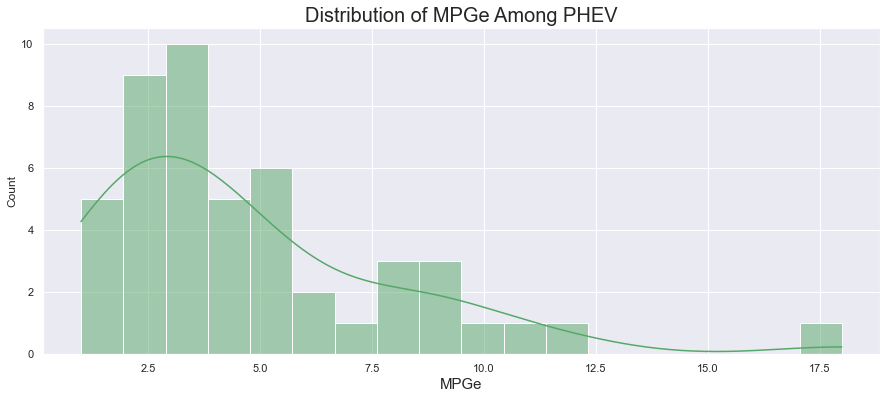

''

In [204]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Distribution of MPGe Among PHEV', size = 20)
sns.histplot(x = df[df.phevComb > 0].phevComb.value_counts(), bins = 18, kde=True, color = 'g')
ax.set_xlabel('MPGe', size=15)
plt.show()
;

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Distribution of MPGe Among PHEV', size = 20)
sns.histplot(x = df[df.cmc == 1].chil, bins = 12, kde = True, color = 'g', alpha = .6)
sns.histplot(x = df[df.cmc != 1].chil, bins = 12, kde = True, color = 'y', alpha = .4)
ax.set_xlabel('Child Count', size=15)
ax.legend(labels=['No contraception', 'Uses contraception'])
plt.show()
;

### `cylinders`

- 283 null values in this column
  - 280 of them are electric vehicles. The values for these have been set to 0.
  - 2 are Suburu RX Turbos from the same year. Imputed value to 4 (though these will probably get dropped due to having NaN values for `eng_dscr`
  - 1 is a Mazda RX that is a duplicate entry and will be **dropped**

In [41]:
df.cylinders.value_counts()

4.0     16950
6.0     14945
8.0      9270
5.0       774
12.0      675
3.0       343
10.0      179
2.0        63
16.0       14
Name: cylinders, dtype: int64

In [136]:
len(df[df.fuelType == 'Electricity'].cylinders)

280

In [140]:
df[(df.fuelType != 'Electricity') & (df.cylinders.isna())]

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
21410,13.733750,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,370.291667,24,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,4-Wheel Drive,0,NaN,-1,1800,0,Regular,Regular Gasoline,-1,-1,28,0.0,0,0.0,0.0,0.0,0.0,0,0,29472,0,0,Subaru,RX Turbo,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,27.4000,0.0,38.8000,0.0,Subcompact Cars,1985,-1000,0,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21411,14.330870,0.0,0.0,0.0,21,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,386.391304,23,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,4-Wheel Drive,0,CA model,-1,1850,0,Regular,Regular Gasoline,-1,-1,27,0.0,0,0.0,0.0,0.0,0.0,0,0,29473,0,0,Subaru,RX Turbo,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,26.9000,0.0,37.1000,0.0,Subcompact Cars,1985,-1250,0,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21500,18.311667,0.0,0.0,0.0,15,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,493.722222,18,0.0,0,0.0,0.0,0.0,0.0,NaN,1.3,Rear-Wheel Drive,0,NaN,-1,2400,0,Regular,Regular Gasoline,-1,-1,22,0.0,0,0.0,0.0,0.0,0.0,0,0,29557,0,0,Mazda,RX-7,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,19.0473,0.0,31.1094,0.0,Two Seaters,1986,-4000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0


In [149]:
df[(df.make == 'Subaru') & (df.year < 1994)]

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
4,17.347895,0.0,0.0,0.0,17,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,467.736842,19,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,66031,"(FFS,TRBO)",-1,2750,0,Premium,Premium Gasoline,-1,-1,23,0.0,0,0.0,0.0,0.0,0.0,0,0,10000,0,14,Subaru,Legacy AWD Turbo,N,False,0,90,0,0.0,0.0,0.0,0.0,Manual 5-spd,21.0000,0.0,32.0000,0.0,Compact Cars,1993,-5750,0,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
5,14.982273,0.0,0.0,0.0,21,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,403.954545,22,0.0,0,0.0,0.0,0.0,0.0,4.0,1.8,Front-Wheel Drive,66020,(FFS),-1,1950,0,Regular,Regular Gasoline,-1,-1,24,0.0,0,0.0,0.0,0.0,0.0,0,0,10001,0,15,Subaru,Loyale,N,False,0,88,0,0.0,0.0,0.0,0.0,Automatic 3-spd,27.0000,0.0,33.0000,0.0,Compact Cars,1993,-1750,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
6,13.184400,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,355.480000,25,0.0,0,0.0,0.0,0.0,0.0,4.0,1.8,Front-Wheel Drive,66020,(FFS),-1,1700,0,Regular,Regular Gasoline,-1,-1,29,0.0,0,0.0,0.0,0.0,0.0,0,0,10002,0,15,Subaru,Loyale,Y,False,0,88,0,0.0,0.0,0.0,0.0,Manual 5-spd,28.0000,0.0,41.0000,0.0,Compact Cars,1993,-500,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
173,14.982273,0.0,0.0,0.0,19,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,403.954545,22,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,Front-Wheel Drive,66030,(FFS),-1,1950,0,Regular,Regular Gasoline,-1,-1,26,0.0,0,0.0,0.0,0.0,0.0,0,0,10153,0,36,Subaru,Legacy Wagon,Y,False,0,92,0,0.0,0.0,0.0,0.0,Automatic 4-spd,24.0000,0.0,37.0000,0.0,Small Station Wagons,1993,-1750,0,CLKUP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
174,14.330870,0.0,0.0,0.0,20,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,386.391304,23,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,Front-Wheel Drive,66030,(FFS),-1,1850,0,Regular,Regular Gasoline,-1,-1,28,0.0,0,0.0,0.0,0.0,0.0,0,0,10154,0,36,Subaru,Legacy Wagon,N,False,0,92,0,0.0,0.0,0.0,0.0,Manual 5-spd,25.0000,0.0,39.0000,0.0,Small Station Wagons,1993,-1250,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
175,15.695714,0.0,0.0,0.0,18,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,423.190476,21,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,66030,(FFS),-1,2050,0,Regular,Regular Gasoline,-1,-1,24,0.0,0,0.0,0.0,0.0,0.0,0,0,10155,0,36,Subaru,Legacy Wagon AWD,Y,False,0,92,0,0.0,0.0,0.0,0.0,Automatic 4-spd,23.0000,0.0,34.0000,0.0,Small Station Wagons,1993,-2250,0,CLKUP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
176,15.695714,0.0,0.0,0.0,18,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,423.190476,21,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,66030,(FFS),-1,2050,0,Regular,Regular Gasoline,-1,-1,24,0.0,0,0.0,0.0,0.0,0.0,0,0,10156,0,36,Subaru,Legacy Wagon AWD,Y,False,0,92,0,0.0,0.0,0.0,0.0,Manual 5-spd,23.0000,0.0,34.0000,0.0,Small Station Wagons,1993,-2250,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
177,18.311667,0.0,0.0,0.0,16,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,493.722222,18,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,4-Wheel or All-Wheel Drive

In [148]:
df[(df.make == 'Subaru') & (df.model == 'RX Turbo')] # impute cylinders to 4

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
21410,13.73375,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,370.291667,24,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,4-Wheel Drive,0,NaN,-1,1800,0,Regular,Regular Gasoline,-1,-1,28,0.0,0,0.0,0.0,0.0,0.0,0,0,29472,0,0,Subaru,RX Turbo,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,27.4,0.0,38.8,0.0,Subcompact Cars,1985,-1000,0,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21411,14.33087,0.0,0.0,0.0,21,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,386.391304,23,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,4-Wheel Drive,0,CA model,-1,1850,0,Regular,Regular Gasoline,-1,-1,27,0.0,0,0.0,0.0,0.0,0.0,0,0,29473,0,0,Subaru,RX Turbo,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,26.9,0.0,37.1,0.0,Subcompact Cars,1985,-1250,0,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0


In [146]:
df[(df.make == 'Mazda') & (df.model == 'RX-7') & (df.year == 1986)] # drop the lower, appears to be a duplicate

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
8145,18.311667,0.0,0.0,0.0,15,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,493.722222,18,0.0,0,0.0,0.0,0.0,0.0,2.0,1.3,Rear-Wheel Drive,56010,(FFS),-1,2400,0,Regular,Regular Gasoline,-1,-1,22,0.0,0,0.0,0.0,0.0,0.0,0,0,1733,10,0,Mazda,RX-7,Y,False,69,0,0,0.0,0.0,0.0,0.0,Automatic 4-spd,19.0000,0.0,30.7692,0.0,Minicompact Cars,1986,-4000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21500,18.311667,0.0,0.0,0.0,15,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,493.722222,18,0.0,0,0.0,0.0,0.0,0.0,NaN,1.3,Rear-Wheel Drive,0,NaN,-1,2400,0,Regular,Regular Gasoline,-1,-1,22,0.0,0,0.0,0.0,0.0,0.0,0,0,29557,0,0,Mazda,RX-7,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,19.0473,0.0,31.1094,0.0,Two Seaters,1986,-4000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0


In [154]:
df[(df.make == 'Subaru') & (df.model == 'RX Turbo')]

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
21410,13.73375,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,370.291667,24,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,4-Wheel Drive,0,NaN,-1,1800,0,Regular,Regular Gasoline,-1,-1,28,0.0,0,0.0,0.0,0.0,0.0,0,0,29472,0,0,Subaru,RX Turbo,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,27.4,0.0,38.8,0.0,Subcompact Cars,1985,-1000,0,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21411,14.33087,0.0,0.0,0.0,21,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,386.391304,23,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,4-Wheel Drive,0,CA model,-1,1850,0,Regular,Regular Gasoline,-1,-1,27,0.0,0,0.0,0.0,0.0,0.0,0,0,29473,0,0,Subaru,RX Turbo,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,26.9,0.0,37.1,0.0,Subcompact Cars,1985,-1250,0,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0


In [138]:
df.cylinders.isna().sum()

283

In [128]:
df[df.cylinders.isna()][['fuelType', 'fuelType1', 'fuelType2', 'make', 'model', 'year', 'eng_dscr']]

,fuelType,fuelType1,fuelType2,make,model,year,eng_dscr
7138,Electricity,Electricity,NaN,Nissan,Altra EV,2000,NaN
7139,Electricity,Electricity,NaN,Toyota,RAV4 EV,2000,NaN
8143,Electricity,Electricity,NaN,Toyota,RAV4 EV,2001,NaN
8144,Electricity,Electricity,NaN,Ford,Th!nk,2001,NaN
8146,Electricity,Electricity,NaN,Ford,Explorer USPS Electric,2001,NaN
8147,Electricity,Electricity,NaN,Nissan,Hyper-Mini,2001,NaN
9212,Electricity,Electricity,NaN,Toyota,RAV4 EV,2002,NaN
9213,Electricity,Electricity,NaN,Ford,Explorer USPS Electric,2002,NaN
10329,Electricity,Electricity,NaN,Toyota,RAV4 EV,2003,NaN
21410,Regular,Regular Gasoline,NaN,Subaru,RX Turbo,1985,NaN


### `trany`

### `trans_dscr`

### `eng_dscr`

- [Engine descriptions](https://www.fueleconomy.gov/feg/descriptors.htm)
- this is a mess but will have major impact on MPG target.

In [221]:
df.eng_dscr.value_counts()

(FFS)                                       8827
SIDI                                        6890
(FFS) CA model                               926
(FFS)      (MPFI)                            734
FFV                                          703
(FFS,TRBO)                                   666
SIDI & PFI                                   477
(350 V8) (FFS)                               411
(GUZZLER)  (FFS)                             366
SOHC                                         354
SIDI; FFV                                    314
(NO-CAT)                                     238
FLEX-FUEL                                    198
GUZZLER                                      195
(FFS)      (SPFI)                            194
SIDI; PHEV                                   155
(GUZZLER)  (FFS)      (MPFI)                 122
(350 V8)                                     120
SIDI; Mild Hybrid                            117
CA model                                     113
(350 V8) (FFS)  (MPF

### `evMotor`

- Messy but will have a major impact on MPGe target.

In [224]:
df.evMotor.value_counts()

288V Ni-MH                                             138
48V Li-Ion                                             113
245V Ni-MH                                              57
270V Li-Ion                                             39
144V Li-Ion                                             28
240V Li-Ion                                             27
280V Li-Ion                                             27
259V Li-Ion                                             26
330V Ni-MH                                              26
202V Ni-MH                                              26
70 kW DC Brushless                                      24
346V Li-Ion                                             21
34 and 65kW 3-phase Sync.                               17
80 kW DCPM                                              17
101V Ni-MH                                              17
86V Li-Ion                                              14
125 kW AC Induction                                     

### displ

- **displ** - engine displacement in liters

### drive

- **drive** - drive axle type

###  `fuelType1` / `fuelType2`

- **fuelType** - fuel type with fuelType1 and fuelType2 (if applicable) **DROP**
- **fuelType1** - fuel type 1. For single fuel vehicles, this will be the only fuel. For dual fuel vehicles, this **will** be the conventional fuel.
- **fuelType2** - fuel type 2. For dual fuel vehicles, this will be the alternative fuel (e.g. E85, Electricity, CNG, LPG). For single fuel vehicles, this field is not used.

- Drop either `fuelType1` and `fuelType2` and keep the non-numbered feature, or drop the latter two and keep `fuelType`. The latter two combined privide the same info as the first.  
- I'm mad curious what a propane-powered vehicle looks like.  
> Hint: it's Ford tough.

In [74]:
type(df.iloc[2:3].fuelType)

pandas.core.series.Series

In [60]:
df.fuelType.value_counts()

Regular                        27420
Premium                        12672
Gasoline or E85                 1352
Diesel                          1203
Electricity                      280
Midgrade                         130
Premium or E85                   127
Premium and Electricity          100
Regular Gas and Electricity       63
CNG                               60
Premium Gas or Electricity        57
Gasoline or natural gas           20
Gasoline or propane                8
Regular Gas or Electricity         4
Name: fuelType, dtype: int64

In [62]:
df.fuelType1.value_counts()

Regular Gasoline     28867
Premium Gasoline     12956
Diesel                1203
Electricity            280
Midgrade Gasoline      130
Natural Gas             60
Name: fuelType1, dtype: int64

In [63]:
df.fuelType2.value_counts()

E85            1479
Electricity     224
Natural Gas      20
Propane           8
Name: fuelType2, dtype: int64

- **ghgScore** - EPA GHG score (-1 = Not available)
- **ghgScoreA** - EPA GHG score for dual fuel vehicle running on the alternative fuel (-1 = Not available)

- Green House Gas Score
- supposed to be a range from 1-10, but class imbalance towards -1 values (score for vehicle not available)
  - **DROP**
  - imputing is risky. It would be possible, if I take the median score for other vehicles in the same body style class with similar mechanical features, but that would be very presumptuous.

In [58]:
df.ghgScore.value_counts()

-1     32012
 5      2889
 4      2319
 6      1576
 3      1448
 7      1193
 2       588
 8       579
 10      460
 1       256
 9       176
Name: ghgScore, dtype: int64

In [59]:
df.ghgScoreA.value_counts()

-1    42819
 4      173
 5      140
 3      140
 6       91
 2       72
 1       20
 7       16
 8       13
 0       12
Name: ghgScoreA, dtype: int64

### `lv2` / `lv4`

### `pv2` /  `pv4`

In [228]:
df.pv2.value_counts()

0      36477
84       395
85       385
70       384
81       369
89       328
82       315
91       306
90       283
80       278
87       271
78       263
76       261
88       237
68       221
86       220
98       199
77       198
92       194
83       181
74       158
93       147
79       146
96       143
94       141
97       113
75       110
95       104
99        73
48        54
102       50
72        44
100       40
55        36
50        35
101       32
52        31
49        23
109       22
64        21
106       21
107       18
6         18
105       15
71        14
110       14
46        11
56        11
10        10
69         9
7          8
73         8
67         8
9          6
45         6
43         5
103        5
193        4
8          3
194        3
47         2
1          2
40         2
2          1
51         1
28         1
108        1
Name: pv2, dtype: int64

In [229]:
df.pv4.value_counts()

0      28279
91      1086
97      1000
89       941
90       935
100      827
94       772
98       735
96       709
88       599
95       578
99       561
92       545
102      543
93       517
101      447
105      370
86       366
104      341
103      324
106      272
87       264
108      264
84       253
85       207
110      196
107      180
112      157
80       140
111      137
109      132
83       122
114       98
82        82
115       69
113       57
79        51
81        47
77        37
48        25
116       20
78        18
128       16
143       14
118       14
120       13
117       12
121       12
125       12
124       12
72        12
148       11
76         9
71         6
70         5
157        5
127        5
74         5
75         4
64         3
139        3
5          3
68         2
144        2
147        1
189        1
176        1
192        1
136        1
156        1
4          1
53         1
187        1
6          1
154        1
149        1
Name: pv4, d

### `hpv` /  `hlv`

- **hlv** - hatchback luggage volume (cubic feet) (8)
- **hpv** - hatchback passenger volume (cubic feet) (8)

- Combine with other vehicle volume info

In [227]:
df.hlv.value_counts()

0     38389
12      517
15      513
16      474
17      463
13      382
18      333
10      234
19      230
11      223
14      189
22      183
8       165
9       128
23      123
20      110
26       97
24       95
21       88
35       78
25       75
7        69
36       60
39       49
27       44
32       36
34       25
42       24
37       16
5        16
4        14
31       12
30        8
46        8
6         7
33        6
41        5
44        4
49        2
28        1
Name: hlv, dtype: int64

### `phevBlended`

- **phevBlended** - if true, this vehicle operates on a blend of gasoline and electricity in charge depleting

- Binary class. Will set 'True' values to 1 and 'False' values to 0.

In [209]:
df.phevBlended

0    43495
Name: phevBlended, dtype: int64

### `startStop`

- **startStop** - vehicle has start-stop technology (Y, N, or blank for older vehicles)  
The NaN values are manageable. This should be a **binary** class.

In [181]:
df.startStop.value_counts()

N    7186
Y    4621
Name: startStop, dtype: int64

In [183]:
df.startStop.value_counts()

0    38874
1     4621
Name: startStop, dtype: int64

- **trans_dscr** - transmission descriptor; see http://www.fueleconomy.gov/feg/findacarhelp.shtml#trany

- Will **one hot encode** these classes. 
- I will do further research in to the difference and consolodate the transmissions with lower value counts in to the classes that they are most similar to.
- on second thought, $\frac{2}{3}$ of these are null. **DROP**

In [220]:
df.trans_dscr.isna().value_counts()

True     28451
False    15044
Name: trans_dscr, dtype: int64

In [217]:
df[df.trans_dscr == 'SIL'].trany.value_counts()

Manual 5-spd       1887
Manual 4-spd        277
Manual 6-spd         18
Automatic 4-spd       7
Name: trany, dtype: int64

In [213]:
df.trans_dscr.value_counts()

CLKUP              7809
SIL                2189
2MODE CLKUP        1235
Creeper             525
EMS 2MODE CLKUP     517
3MODE CLKUP         517
2MODE               448
2MODE 2LKUP         383
EMS                 252
3MODE               166
CMODE               150
CMODE CLKUP         130
VMODE CLKUP         105
SIL Creeper          72
2LKUP                63
DC/FW                53
VLKUP                52
EMS CLKUP            50
EMS 2MODE            46
6MODE CLKUP          41
4MODE                35
VMODE VLKUP          26
2MODE 3LKUP          22
2MODE DC/FW          19
CMODE VLKUP          17
3LKUP                15
EMS 3MODE            11
Overdrive            10
Lockup                9
2MODE VLKUP           9
SIL EMS               7
4MODE CLKUP           6
SIL 3MODE             6
6MODE                 6
EMS 2MODE CLKU        5
SIL 2MODE CLKUP       5
3MODE VLKUP           5
Mech Overdrive        3
Elec Overdrive        3
EMS 3MODE CLKUP       3
SIL CMODE             2
SIL 3MODE CLKUP 

### `VClass`

- **VClass** - EPA vehicle size class

In [239]:
df.VClass.value_counts()

Compact Cars                          6089
Subcompact Cars                       5388
Midsize Cars                          5197
Large Cars                            2373
Standard Pickup Trucks                2354
Two Seaters                           2215
Sport Utility Vehicle - 4WD           2078
Small Station Wagons                  1662
Sport Utility Vehicle - 2WD           1627
Special Purpose Vehicles              1455
Minicompact Cars                      1454
Standard Pickup Trucks 2WD            1335
Standard Pickup Trucks 4WD            1195
Small Sport Utility Vehicle 4WD       1164
Vans                                  1141
Standard Sport Utility Vehicle 4WD     911
Small Sport Utility Vehicle 2WD        765
Special Purpose Vehicle 2WD            700
Midsize-Large Station Wagons           656
Midsize Station Wagons                 566
Small Pickup Trucks                    538
Small Pickup Trucks 2WD                489
Vans, Cargo Type                       438
Minivan - 2

### `guzzler`

- **guzzler** - if `'G'` or `'T'`, this vehicle is subject to the gas guzzler tax  
- there are 15 vehicles with a mysteries `'S'` classification. Further inspection reveals that these are either polic vehicles, or supercars. These will be encoded to 1 as well. 
- **converted to binary** 1 = yes / 0 = no  
- There will likely be multi-colinearity with `eng_dscr`, however I can not cross correlate between categorical and numerical values without converting one to the other.

In [110]:
df.guzzler.value_counts()

G    1583
T     964
S      15
Name: guzzler, dtype: int64

In [114]:
df[df.guzzler == 'S']

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
21072,19.388824,0.0,0.0,0.0,14,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,522.764706,17,0.0,0,0.0,0.0,0.0,0.0,8.0,4.6,Rear-Wheel Drive,0,GUZZLER POLICE 4.6N,-1,2500,0,Regular,Regular Gasoline,-1,-1,20,0.0,0,0.0,0.0,0.0,0.0,0,0,29159,0,0,Ford,Crown Victoria Police,N,False,0,0,0,0.0,0.0,0.0,0.0,Automatic 4-spd,17.8000,0.0,28.1000,0.0,Large Cars,1998,-4500,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21075,25.354615,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,683.615385,13,0.0,0,0.0,0.0,0.0,0.0,10.0,8.0,Rear-Wheel Drive,0,GUZZLER FFS,-1,4050,0,Premium,Premium Gasoline,-1,-1,19,0.0,0,0.0,0.0,0.0,0.0,0,0,29161,0,0,Dodge,Viper Convertible,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 6-spd,12.6424,0.0,25.7276,0.0,Two Seaters,1999,-12250,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21076,25.354615,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,683.615385,13,0.0,0,0.0,0.0,0.0,0.0,10.0,8.0,Rear-Wheel Drive,0,GUZZLER FFS,-1,4050,0,Premium,Premium Gasoline,-1,-1,19,0.0,0,0.0,0.0,0.0,0.0,0,0,29162,0,0,Dodge,Viper Coupe,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 6-spd,12.6424,0.0,25.7276,0.0,Two Seaters,1999,-12250,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21077,29.964545,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,807.909091,11,0.0,0,0.0,0.0,0.0,0.0,8.0,3.6,Rear-Wheel Drive,0,GUZZLER FFS,-1,4800,0,Premium,Premium Gasoline,-1,-1,15,0.0,0,0.0,0.0,0.0,0.0,0,0,29163,0,0,Ferrari,360 Modena/Modena F1,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 6-spd,11.8000,0.0,20.3000,0.0,Two Seaters,1999,-16000,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21078,27.467500,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,740.583333,12,0.0,0,0.0,0.0,0.0,0.0,8.0,3.6,Rear-Wheel Drive,0,GUZZLER FFS,-1,4400,0,Premium,Premium Gasoline,-1,-1,15,0.0,0,0.0,0.0,0.0,0.0,0,0,29164,0,0,Ferrari,360 Modena/Modena F1,N,False,0,0,0,0.0,0.0,0.0,0.0,Automatic 6-spd,12.2992,0.0,21.0356,0.0,Two Seaters,1999,-14000,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21079,21.974000,0.0,0.0,0.0,13,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,592.466667,15,0.0,0,0.0,0.0,0.0,0.0,8.0,3.5,Rear-Wheel Drive,0,"GUZZLER V8 FFS,TURBO",-1,3500,0,Premium,Premium Gasoline,-1,-1,20,0.0,0,0.0,0.0,0.0,0.0,0,0,29165,0,0,Lotus,Esprit V8,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,15.7000,0.0,28.3000,0.0,Two Seaters,1999,-9500,S,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21092,19.388824,0.0,0.0,0.0,15,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,522.764706,17,0.0,0,0.0,0.0,0.0,0.0,8.0,5.4,Rear-Wheel Drive,0,GUZZLER FFS,-1,3100,0,Premium,Premium Gasoline,-1,-1,21,0.0,0,0.0,0.0,0.0,0.0,0,0,29178,0,0,Mercedes-Benz,E55 AMG,Y,False,0,0,0,0.0,0.0,0.0,0.0,Automatic 5-spd,18.3000,0.0,29.3000,0.0,Midsize Cars,1999,-7500,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
21121,20.600625,0.0,0.0,0.0,14,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,555.437500,16,0.0,0,0.0,0.0,0.0,0.0,8.0,4.6,Rear-Wheel Drive,0,GUZZLER POLICE 4.6

### co2-x — ?

- **co2** - tailpipe CO2 in grams/mile for fuelType1 (5)
- **co2A** - tailpipe CO2 in grams/mile for fuelType2 (5)
- **co2TailpipeAGpm** - tailpipe CO2 in grams/mile for fuelType2 (5)
- **co2TailpipeGpm**- tailpipe CO2 in grams/mile for fuelType1 (5)  
  
  
Curious, both the `TailpipeGpm` and alternative features have the same description. Let's see if they have the same values.

In [24]:
(df.co2 == df.co2TailpipeGpm).value_counts()

False    31939
True     11557
dtype: int64

In [25]:
(df.co2A == df.co2TailpipeAGpm).value_counts()

False    42850
True       646
dtype: int64

Peculiarly, their contents match in $\frac{1}{4}$ of vehicles for fuelType1, and in $\frac{1}{66}$ of vehicles for fuelType2. 

### `mpgData` — ?

- **mpgData** - has My MPG data; see yourMpgVehicle and yourMpgDriverVehicle
- I'm a bit confused as to what this represents. Worth seeing if dataset source has further info.

In [52]:
df.mpgData.value_counts()

N    29801
Y    13689
Name: mpgData, dtype: int64

## Dropped

### `comb08` / `combA08` — DROPPED

### `city`-x — DROPPED

### `ghgScore` / `ghgScoreA` — DROPPED

- **ghgScore** - EPA GHG score (-1 = Not available)
- **ghgScoreA** - EPA GHG score for dual fuel vehicle running on the alternative fuel (-1 = Not available)

In [232]:
df.ghgScore.value_counts()

-1     32011
 5      2889
 4      2319
 6      1576
 3      1448
 7      1193
 2       588
 8       579
 10      460
 1       256
 9       176
Name: ghgScore, dtype: int64

- **city08** - city MPG for fuelType1 (2), (11)
- **city08U** - unrounded city MPG for fuelType1 (2), (3)
- **cityA08** - city MPG for fuelType2 (2)
- **cityA08U** - unrounded city MPG for fuelType2 (2), (3)  
  
  
- **cityCD** - city gasoline consumption (gallons/100 miles) in charge depleting mode    
- **cityE** - city electricity consumption in kw-hrs/100 miles  
- **cityUF** - EPA city utility factor (share of electricity) for PHEV

The **city** features represent similar factors across their different attributes.  
- The first four represent MPG/city for different fuel types (**fuelType1 = `08`, fuelType2 = `A08`**)  
  - The above types are also represented separately for attributes that indicate that the values are unrounded (**`08` vs `08U`, `A08` vs `A08U`**)  
  - These will be cross evaluated to decide which to **drop**.
- **`cityCD`** represents city gasoline consumption in charge depleting mode (i.e.—when the car battery is on and not recharging, which is all the time for EVs, and when the engine is off but the key is still on in the ignition for ICE vehicles).
  - **THIS FEATURE WILL BE DROPPED**. Only 41 listed vehicles have non-zero values. 
- **`cityE`** represents city electricity consumption in kw-hrs/100 miles.  
  - There are 504 rows with non-zero values.
  - Deciding whether to **drop** will depend on further EDA.
- **`cityUF`** represents a factor for PHEVs
  - **THIS FEATURE WILL BE DROPPED**. Only 224 listed vehicles have non-zero values.  
    - however they are not null... would possibly be useful if other indicators for hybrid vehicles are not as useful.

In [27]:
df.cityCD.value_counts()

0.0000    43456
0.1000       19
0.3500        4
0.6000        3
0.5000        3
5.3500        2
0.0603        2
0.8700        1
0.0980        1
0.0972        1
0.2000        1
0.8667        1
1.2000        1
0.8339        1
Name: cityCD, dtype: int64

In [39]:
df[df.cityE != 0].cityUF.value_counts().sum()

504

In [36]:
df[df.cityUF != 0].cityUF.value_counts().sum()

224

In [33]:
df.cityUF.value_counts()

0.0000    43272
0.4781        8
0.3570        6
0.7480        6
0.9270        6
0.3350        6
0.4440        6
0.5530        5
0.6400        4
0.4920        4
0.3380        4
0.5610        4
0.4170        4
0.4390        4
0.5050        3
0.3460        3
0.3678        3
0.3010        3
0.6300        3
0.3560        3
0.8000        3
0.5580        3
0.4430        3
0.4980        3
0.3200        3
0.5680        3
0.5590        3
0.3660        3
0.7780        3
0.3710        3
0.6800        3
0.3180        3
0.3960        3
0.3980        3
0.5890        3
0.8490        3
0.6500        2
0.8950        2
0.6700        2
0.3840        2
0.4360        2
0.4190        2
0.3370        2
0.4350        2
0.3440        2
0.4460        2
0.7740        2
0.4790        2
0.3790        2
0.4680        2
0.3240        2
0.5640        2
0.3270        2
0.3970        2
0.4340        2
0.3330        2
0.5900        1
0.4550        1
0.3339        1
0.4690        1
0.4400        1
0.4810        1
0.5410  

### `feScore` — DROPPED

- **feScore** - EPA Fuel Economy Score (-1 = Not available)
- Too many NaN values. **DROP**.

In [226]:
df.feScore.value_counts()

-1     32011
 5      2946
 4      2259
 6      1596
 3      1440
 7      1168
 8       646
 2       588
 10      408
 1       257
 9       176
Name: feScore, dtype: int64

### `fuelCost08` / `fuelCostA08` — DROPPED

- **fuelCost08** - annual fuel cost for fuelType1 ($\$$) 
- **fuelCostA08** - annual fuel cost for fuelType2 ($\$$)

- **Drop**. Price will not effect MPG (though may be insightful for market trends, what cars are being purchased etc.).

### `fuelType` — DROPPED  

### `youSaveSpend` — DROPPED

- **DROP**

### `UCity`-x / `UHighway`-x — DROPPED

### `highway`-x — DROPPED

### `phevCity` / `phevHwy` 

- **phevCity** - EPA composite gasoline-electricity city MPGe for plug-in hybrid vehicles
- **phevHwy** - EPA composite gasoline-electricity highway MPGe for plug-in hybrid vehicles
- **phevComb** - EPA composite gasoline-electricity combined city-highway MPGe for plug-in hybrid vehicles **TARGET**

These features will be the saving grace of electric cars when comparing to combustion engine equivalent target. Total vehicles that have non-zero values fits with total PHEV vehicles.  
  
I will be using **`phevComb`** as the target for PHEVs.

### `range`-x — DROPPED

- **rangeA** - EPA range for fuelType2
- **rangeCityA** - EPA city range for fuelType2
- **rangeHwyA** - EPA highway range for fuelType2

- **DROP**. Not relevant to target.

### `id` — DROPPED

### `engId` — DROPPED

- **engId** - EPA model type index

- reference index for the EPA
- **DROP**. Unecessary and will cause multicolinearity with `model`

### `mfrCode` — DROPPED

### `createdOn` / `modifiedOn` — DROPPED

- date of record creation and modification
- primary use will be to cross reference dataset updates and ensure they are present in this dataset

## Attribute Descriptions Reference

#### Columns

In [17]:
df.columns

Index(['barrels08', 'barrelsA08', 'charge120', 'charge240', 'city08',
       'city08U', 'cityA08', 'cityA08U', 'cityCD', 'cityE', 'cityUF', 'co2',
       'co2A', 'co2TailpipeAGpm', 'co2TailpipeGpm', 'comb08', 'comb08U',
       'combA08', 'combA08U', 'combE', 'combinedCD', 'combinedUF', 'cylinders',
       'displ', 'drive', 'engId', 'eng_dscr', 'feScore', 'fuelCost08',
       'fuelCostA08', 'fuelType', 'fuelType1', 'ghgScore', 'ghgScoreA',
       'highway08', 'highway08U', 'highwayA08', 'highwayA08U', 'highwayCD',
       'highwayE', 'highwayUF', 'hlv', 'hpv', 'id', 'lv2', 'lv4', 'make',
       'model', 'mpgData', 'phevBlended', 'pv2', 'pv4', 'range', 'rangeCity',
       'rangeCityA', 'rangeHwy', 'rangeHwyA', 'trany', 'UCity', 'UCityA',
       'UHighway', 'UHighwayA', 'VClass', 'year', 'youSaveSpend', 'guzzler',
       'trans_dscr', 'tCharger', 'sCharger', 'atvType', 'fuelType2', 'rangeA',
       'evMotor', 'mfrCode', 'c240Dscr', 'charge240b', 'c240bDscr',
       'createdOn', 'modifiedOn

#### Descriptions

- **barrels08** - annual petroleum consumption in barrels for fuelType1
- **barrelsA08** - annual petroleum consumption in barrels for fuelType2
- **charge120** - time to charge an electric vehicle in hours at 120 V
- **charge240** - time to charge an electric vehicle in hours at 240 V
- **city08** - city MPG for fuelType1
- **city08U** - unrounded city MPG for fuelType1
- **cityA08** - city MPG for fuelType2
- **cityA08U** - unrounded city MPG for fuelType2
- **cityCD** - city gasoline consumption (gallons/100 miles) in charge depleting mode
- **cityE** - city electricity consumption in kw-hrs/100 miles
- **cityUF** - EPA city utility factor (share of electricity) for PHEV
- **co2** - tailpipe CO2 in grams/mile for fuelType1
- **co2A** - tailpipe CO2 in grams/mile for fuelType2
- **co2TailpipeAGpm** - tailpipe CO2 in grams/mile for fuelType2
- **co2TailpipeGpm**- tailpipe CO2 in grams/mile for fuelType1
- **comb08** - combined MPG for fuelType1
- **comb08U** - unrounded combined MPG for fuelType1
- **combA08** - combined MPG for fuelType2
- **combA08U** - unrounded combined MPG for fuelType2
- **combE** - combined electricity consumption in kw-hrs/100 miles
- **combinedCD** - combined gasoline consumption (gallons/100 miles) in charge depleting mode
- **combinedUF** - EPA combined utility factor (share of electricity) for PHEV
- **cylinders** - engine cylinders
- **displ** - engine displacement in liters
- **drive** - drive axle type
- **engId** - EPA model type index
- **eng_dscr** - engine descriptor; see http://www.fueleconomy.gov/feg/findacarhelp.shtml#engine
- **evMotor** - electric motor (kw-hrs)
- **feScore** - EPA Fuel Economy Score (-1 = Not available)
- **fuelCost08** - annual fuel cost for fuelType1 ($\$$) (7)
- **fuelCostA08** - annual fuel cost for fuelType2 ($\$$) (7)
- **fuelType** - fuel type with fuelType1 and fuelType2 (if applicable)
- **fuelType1** - fuel type 1. For single fuel vehicles, this will be the only fuel. For dual fuel vehicles, this **will** be the conventional fuel.
- **fuelType2** - fuel type 2. For dual fuel vehicles, this will be the alternative fuel (e.g. E85, Electricity, CNG, LPG). For single fuel vehicles, this field is not used
- **ghgScore** - EPA GHG score (-1 = Not available)10/10/2018 Fuel Economy Web Services
- **ghgScoreA** - EPA GHG score for dual fuel vehicle running on the alternative fuel (-1 = Not available)
- **guzzler**- if G or T, this vehicle is subject to the gas guzzler tax
- **highway08** - highway MPG for fuelType1 (2), (11)
- **highway08U** - unrounded highway MPG for fuelType1 (2), (3)
- **highwayA08** - highway MPG for fuelType2 (2)
- **highwayA08U** - unrounded highway MPG for fuelType2 (2),(3)
- **highwayCD** - highway gasoline consumption (gallons/100miles) in charge depleting mode (4)
- **highwayE** - highway electricity consumption in kw-hrs/100 miles
- **highwayUF** - EPA highway utility factor (share of electricity) for PHEV
- **hlv** - hatchback luggage volume (cubic feet) (8)
- **hpv** - hatchback passenger volume (cubic feet) (8)
- **id** - vehicle record id
- **lv2** - 2 door luggage volume (cubic feet) (8)
- **lv4** - 4 door luggage volume (cubic feet) (8)
- **make** - manufacturer (division)
- **mfrCode** - 3-character manufacturer code
- **model** - model name (carline)
- **mpgData** - has My MPG data; see yourMpgVehicle and yourMpgDriverVehicle
- **phevBlended** - if true, this vehicle operates on a blend of gasoline and electricity in charge depleting
- **mode**
- **pv2** - 2-door passenger volume (cubic feet) (8)
- **pv4** - 4-door passenger volume (cubic feet) (8)
- **rangeA** - EPA range for fuelType2
- **rangeCityA** - EPA city range for fuelType2
- **rangeHwyA** - EPA highway range for fuelType2
- **trans_dscr** - transmission descriptor; see http://www.fueleconomy.gov/feg/findacarhelp.shtml#trany
- **trany** - transmission
- **UCity** - unadjusted city MPG for fuelType1; see the description of the EPA test procedures
- **UCityA** - unadjusted city MPG for fuelType2; see the description of the EPA test procedures
- **UHighway** - unadjusted highway MPG for fuelType1; see the description of the EPA test procedures
- **UHighwayA** - unadjusted highway MPG for fuelType2; see the description of the EPA test procedures
- **VClass** - EPA vehicle size class
- **year** - model year
- **youSaveSpend** - you save/spend over 5 years compared to an average car ($\$$). Savings are positive; a
- **greater** amount spent yields a negative number. For dual fuel vehicles, this is the cost savings for gasoline
- **sCharger** - if S, this vehicle is supercharged10/10/2018 Fuel Economy Web Services
- **tCharger** - if T, this vehicle is turbocharged
- **c240Dscr** - electric vehicle charger description
- **charge240b** - time to charge an electric vehicle in hours at 240 V using the alternate charger
- **c240bDscr** - electric vehicle alternate charger description
- **createdOn** - date the vehicle record was created (ISO 8601 format)
- **modifiedOn** - date the vehicle record was last modified (ISO 8601 format)
- **startStop** - vehicle has start-stop technology (Y, N, or blank for older vehicles)
- **phevCity** - EPA composite gasoline-electricity city MPGe for plug-in hybrid vehicles
- **phevHwy** - EPA composite gasoline-electricity highway MPGe for plug-in hybrid vehicles
- **phevComb** - EPA composite gasoline-electricity combined city-highway MPGe for plug-in hybrid vehicles

In [ ]:
df = df[['barrels08', 
         'barrelsA08', 
         'charge120', 
         'charge240', 
         'city08', 
         'city08U', 
         'cityA08', 
         'cityA08U', 
         'cityCD', 
         'cityE', 
         'cityUF', 
         'co2',
         'co2A', 
         'co2TailpipeAGpm', 
         'co2TailpipeGpm', 
         'comb08', 
         'comb08U',
         'combA08', 
         'combA08U', 
         'combE', 
         'combinedCD', 
         'combinedUF', 
         'cylinders', # clean
         'displ', 
         'drive', 
         'engId', 
         'eng_dscr', 
         'feScore', 
         'fuelCost08',
         'fuelCostA08', 
         'fuelType', 
         'fuelType1', 
#          'ghgScore', 
#          'ghgScoreA',
         'highway08', 
         'highway08U', 
         'highwayA08', 
         'highwayA08U', 
         'highwayCD',
         'highwayE', 
         'highwayUF', 
         'hlv', 
         'hpv', 
         'id', 
         'lv2', 
         'lv4', 
         'make', # drop when modeling
         'model', # drop when modeling
         'mpgData', 
         'phevBlended', 
         'pv2', 
         'pv4', 
         'range', 
         'rangeCity',
         'rangeCityA', 
         'rangeHwy', 
         'rangeHwyA', 
         'trany', 
         'UCity', 
         'UCityA',
         'UHighway', 
         'UHighwayA', 
         'VClass', 
         'year', 
         'youSaveSpend', 
         'guzzler', # cleaned, may drop due to relation to eng_dscr
         'trans_dscr', 
         'tCharger', 
         'sCharger', 
         'atvType', 
         'fuelType2', 
         'rangeA',
         'evMotor', 
         'mfrCode', 
         'c240Dscr', 
         'charge240b', 
         'c240bDscr',
         'createdOn', 
         'modifiedOn', 
         'startStop', 
         'phevCity', 
         'phevHwy',
         'phevComb']]

# Scrap Paper

In [94]:
df[(df.model == 'F150 Pickup 2WD') & (df.year == 1984)].engId.values

array([3817, 3825, 3828, 3826, 3839, 3837, 3834, 3838, 3851, 3849, 3850,
       3857, 3876, 3869, 3874, 3873, 3886, 3891, 3828])

In [81]:
df[(df.model == 'F150 Pickup 2WD') & (df.year == 1984)].trany.value_counts()

Automatic 3-spd    6
Manual 4-spd       5
Automatic 4-spd    4
Manual 3-spd       3
Name: trany, dtype: int64

In [89]:
df.engId.unique

<bound method Series.unique of 0         9011
1        22020
2         2100
3         2850
4        66031
         ...  
43491    66030
43492    66030
43493    66030
43494    66030
43495    66031
Name: engId, Length: 43496, dtype: int64>

In [87]:
df.iloc[19095]

barrels08                               29.9645
barrelsA08                                    0
charge120                                     0
charge240                                     0
city08                                       11
city08U                                       0
cityA08                                       0
cityA08U                                      0
cityCD                                        0
cityE                                         0
cityUF                                        0
co2                                          -1
co2A                                         -1
co2TailpipeAGpm                               0
co2TailpipeGpm                          807.909
comb08                                       11
comb08U                                       0
combA08                                       0
combA08U                                      0
combE                                         0
combinedCD                              

In [84]:
df.iloc[19092] == df.iloc[19095]

barrels08           True
barrelsA08          True
charge120           True
charge240           True
city08              True
city08U             True
cityA08             True
cityA08U            True
cityCD              True
cityE               True
cityUF              True
co2                 True
co2A                True
co2TailpipeAGpm     True
co2TailpipeGpm      True
comb08              True
comb08U             True
combA08             True
combA08U            True
combE               True
combinedCD          True
combinedUF          True
cylinders           True
displ               True
drive               True
engId              False
eng_dscr           False
feScore             True
fuelCost08          True
fuelCostA08         True
fuelType            True
fuelType1           True
ghgScore            True
ghgScoreA           True
highway08           True
highway08U          True
highwayA08          True
highwayA08U         True
highwayCD           True
highwayE            True


In [83]:
df[(df.model == 'F150 Pickup 2WD') & (df.year == 1984) & (df.trany == 'Automatic 3-spd')]

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
19083,23.543571,0.0,0.0,0.0,13,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,634.785714,14,0.0,0,0.0,0.0,0.0,0.0,6.0,4.9,2-Wheel Drive,3817,(FFS),-1,3050,0,Regular,Regular Gasoline,-1,-1,15,0.0,0,0.0,0.0,0.0,0.0,0,0,27343,0,0,Ford,F150 Pickup 2WD,N,False,0,0,0,0.0,0.0,0.0,0.0,Automatic 3-spd,16.0,0.0,21.0,0.0,Standard Pickup Trucks 2WD,1984,-7250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
19087,27.467500,0.0,0.0,0.0,11,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,740.583333,12,0.0,0,0.0,0.0,0.0,0.0,8.0,5.0,2-Wheel Drive,3839,NaN,-1,3550,0,Regular,Regular Gasoline,-1,-1,12,0.0,0,0.0,0.0,0.0,0.0,0,0,27347,0,0,Ford,F150 Pickup 2WD,N,False,0,0,0,0.0,0.0,0.0,0.0,Automatic 3-spd,14.0,0.0,17.0,0.0,Standard Pickup Trucks 2WD,1984,-9750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
19092,29.964545,0.0,0.0,0.0,11,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,807.909091,11,0.0,0,0.0,0.0,0.0,0.0,8.0,5.8,2-Wheel Drive,3851,(FFS),-1,3900,0,Regular,Regular Gasoline,-1,-1,12,0.0,0,0.0,0.0,0.0,0.0,0,0,27351,0,0,Ford,F150 Pickup 2WD,N,False,0,0,0,0.0,0.0,0.0,0.0,Automatic 3-spd,13.0,0.0,16.0,0.0,Standard Pickup Trucks 2WD,1984,-11500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
19095,29.964545,0.0,0.0,0.0,11,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,807.909091,11,0.0,0,0.0,0.0,0.0,0.0,8.0,5.8,2-Wheel Drive,3857,NaN,-1,3900,0,Regular,Regular Gasoline,-1,-1,12,0.0,0,0.0,0.0,0.0,0.0,0,0,27354,0,0,Ford,F150 Pickup 2WD,N,False,0,0,0,0.0,0.0,0.0,0.0,Automatic 3-spd,13.0,0.0,17.0,0.0,Standard Pickup Trucks 2WD,1984,-11500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
20161,23.543571,0.0,0.0,0.0,13,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,634.785714,14,0.0,0,0.0,0.0,0.0,0.0,6.0,4.9,2-Wheel Drive,3876,(FFS) CA model,-1,3050,0,Regular,Regular Gasoline,-1,-1,15,0.0,0,0.0,0.0,0.0,0.0,0,0,28313,0,0,Ford,F150 Pickup 2WD,N,False,0,0,0,0.0,0.0,0.0,0.0,Automatic 3-spd,16.0,0.0,20.0,0.0,Standard Pickup Trucks 2WD,1984,-7250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
20166,32.961000,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,888.700000,10,0.0,0,0.0,0.0,0.0,0.0,8.0,5.8,2-Wheel Drive,3891,(FFS) CA model,-1,4300,0,Regular,Regular Gasoline,-1,-1,11,0.0,0,0.0,0.0,0.0,0.0,0,0,28318,0,0,Ford,F150 Pickup 2WD,N,False,0,0,0,0.0,0.0,0.0,0.0,Automatic 3-spd,12.0,0.0,15.0,0.0,Standard Pickup Trucks 2WD,1984,-13500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0


# References & Sources

Countries and states setting target years to ban sale of fossil fuel powered vehicles:  
> Reuters, 11/18/2020 — [Fossil fuel-based vehicle bans across the world](https://news.trust.org/item/20201118095737-8h1uh)  
>  
> Reuters, 11/8/2018 — [Germany City Specific Diesel Bans](https://www.reuters.com/article/us-germany-emissions-factbox/factbox-german-cities-ban-older-diesel-cars-idUSKBN1ND1ZV?edition-redirect=in)  
>  
> Insider, 1/12/2019 — [Cities Around the World Enact Plans to Reduce Emissions through Vehicle Restrictions](https://www.businessinsider.com/cities-going-car-free-ban-2018-12#in-paris-the-first-sunday-of-every-month-is-free-of-cars-2)

Fuel economy data sourced from:  
> https://www.fueleconomy.gov/feg/download.shtml

<br><br>